<a href="https://colab.research.google.com/github/readyfornewnormal/Text_Classification/blob/main/MLP_Wikidocs_MLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Q & A

### 1. 한글 + 영문 섞인 데이터 전처링 어떻게? 영어가 대부분이니까 그냥 한글은 삭제 하는게 나으려나?

* bag of words 기반 모델은 관계 없어



# To do

1. 단어 분석
2. 장비명 통일 (라이브러리 검색 및 조교 문의)
3. 원인조직 카테고리 추가
4. 노이즈 제거 - 몇자 이하, 특정 코멘트는 제외

# Code
1. texts_to_matrix() 이해
2. 데이터 세팅
3. MLP 모델링

 ## 1. texts_to_matrix() 이해

In [ ]:
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer

* 케라스 전처리 도구 Tokenizer 임포트 + 정수 인코딩

In [ ]:
texts = ['먹고 싶은 사과', '먹고 싶은 바나나', '길고 노란 바나나 바나나', '저는 과일이 좋아요']

In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(texts)
print(tokenizer.word_index)

{'바나나': 1, '먹고': 2, '싶은': 3, '사과': 4, '길고': 5, '노란': 6, '저는': 7, '과일이': 8, '좋아요': 9}


* texts_to_matrix(): 텍스트 데이터로부터 행렬 생성 (네가지 모드)

In [ ]:
print(tokenizer.texts_to_matrix(texts, mode = 'count'))

[[0. 0. 1. 1. 1. 0. 0. 0. 0. 0.]
 [0. 1. 1. 1. 0. 0. 0. 0. 0. 0.]
 [0. 2. 0. 0. 0. 1. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 1. 1.]]


In [ ]:
print(tokenizer.texts_to_matrix(texts, mode = 'binary'))

[[0. 0. 1. 1. 1. 0. 0. 0. 0. 0.]
 [0. 1. 1. 1. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 1. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 1. 1.]]


In [ ]:
print(tokenizer.texts_to_matrix(texts, mode = 'tfidf').round(2))

[[0.   0.   0.85 0.85 1.1  0.   0.   0.   0.   0.  ]
 [0.   0.85 0.85 0.85 0.   0.   0.   0.   0.   0.  ]
 [0.   1.43 0.   0.   0.   1.1  1.1  0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.   1.1  1.1  1.1 ]]


In [ ]:
print(tokenizer.texts_to_matrix(texts, mode = 'freq').round(2))

[[0.   0.   0.33 0.33 0.33 0.   0.   0.   0.   0.  ]
 [0.   0.33 0.33 0.33 0.   0.   0.   0.   0.   0.  ]
 [0.   0.5  0.   0.   0.   0.25 0.25 0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.33 0.33 0.33]]


## 2. 데이터 세팅

In [ ]:
import pandas as pd
from sklearn.datasets import fetch_20newsgroups
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import to_categorical
import os
import re

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/')

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [ ]:
path = "gdrive/My Drive/Colab Notebooks/data"

In [ ]:
os.listdir("gdrive/My Drive/Colab Notebooks/data")

# 지정한 폴더의 파일을 리스트 형태로 반환

['test.csv', 'train.csv']

In [ ]:
train = pd.read_csv(os.path.join(path,"train.csv"))
test = pd.read_csv(os.path.join(path, "test.csv"))

In [ ]:
print(train.keys())

Index(['index', 'category', 'content'], dtype='object')


In [ ]:
print('훈련용 샘플의 개수 : {}'.format(len(train.content)))

훈련용 샘플의 개수 : 50969


In [ ]:
print('카테고리 개수 : {}'.format(len(train.category)))
print(train.category)

카테고리 개수 : 50969
0        0
1        0
2        0
3        0
4        0
        ..
50964    1
50965    1
50966    1
50967    1
50968    1
Name: category, Length: 50969, dtype: int64


In [ ]:
print(train.content[0])

문제점
OFS1-3BAY 순회점검
B#823 SS1A 용접 진행 중
SHELL BUTT & LONGI 교차부 50V 미시공 용접 진행 확인

조   치
관리자 내용 전달 
해당부 용접부 가우징 및 50V 시공 후 재용접 수정 요청
BUTT 용접성 확보
용접교차부 선용접 또는 50V 시공 관리 독려 바랍니다.


In [ ]:
train['content'] = train['content'].str.replace(r'[-=+,#/\?:^$.@*\"※~&%ㆍ!』\\‘|\(\)\[\]\<\>`\'…》\\n\t]+', " ", regex=True)
test['content'] = test['content'].str.replace(r'[-=+,#/\?:^$.@*\"※~&%ㆍ!』\\‘|\(\)\[\]\<\>`\'…》]', " ", regex=True)
train['content'] = train['content'].str.replace(r'\t+', " ", regex=True)
test['content'] = test['content'].str.replace(r'\t+', " ", regex=True)
train['content'] = train['content'].str.replace(r'[\\n]+'," ", regex=True)
test['content'] = test['content'].str.replace(r'[\\n]+'," ", regex=True) 
train['content'] = train['content'].str.lower()
test['content'] = test['content'].str.lower()

In [ ]:
train_df = pd.DataFrame(train.content, columns = ['content'])
train_df['category'] = pd.Series(train.category)
train_df[:5]

,content,category
0,문제점\r\nofs1 3bay 순회점검\r\nb 823 ss1a 용접 진행 중\r\...,0
1,7 ec scrubber pressure gauge is ot properly ...,0
2,mai e gi es freque t breakages of high press...,0
3,me scr reactor outlet valve ca ot be operated ...,0
4,8 om212v v v v extension 추가 공급 기장배관설계\r\n ...,0


In [ ]:
test_df = pd.DataFrame(test.content, columns = ['content'])
test_df['category'] = pd.Series(test.category)
test_df[:5]

,content,category
0,nitroge sulphur dioxide calibratio gas cyli ...,2
1,all exhaust gas temperature guage o mai e gi...,2
2,aux boiler lsmgo filter fwd drai valve ca o...,2
3,acc n_bridge_bridge deck galley vent battery ...,2
4,purifier room exh damper co trol wire의 ope c...,2


In [ ]:
 # Null 값 확인 / False: Null값 없음

train_df.isnull().values.any()

False

In [ ]:
# 중복 제거

print('중복을 제외한 샘플의 수 : {}'.format(train_df['content'].nunique()))
print('중복을 제외한 카테고리의 수 : {}'.format(train_df['category'].nunique()))

중복을 제외한 샘플의 수 : 43569
중복을 제외한 카테고리의 수 : 4


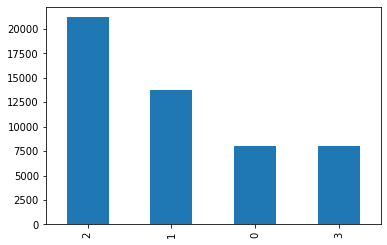

In [ ]:
train_df['category'].value_counts().plot(kind='bar');

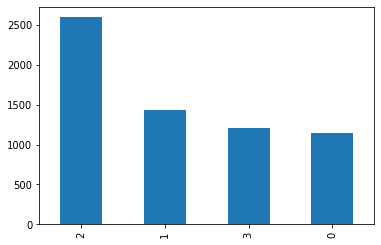

In [ ]:
test_df['category'].value_counts().plot(kind='bar');

In [ ]:
train_content = train_df['content']
train_category = train_df['category']
test_content = test_df['content']
test_category = test_df['category']

In [ ]:
vocab_size = 10000
num_categories = 4

In [ ]:
def prepare_data(train_data, test_data, mode): # 전처리 함수
    tokenizer = Tokenizer(num_words = vocab_size) # vocab_size 개수만큼의 단어만 사용한다.
    tokenizer.fit_on_texts(train_data)
    X_train = tokenizer.texts_to_matrix(train_data, mode=mode) # 샘플 수 × vocab_size 크기의 행렬 생성
    X_test = tokenizer.texts_to_matrix(test_data, mode=mode) # 샘플 수 × vocab_size 크기의 행렬 생성
    return X_train, X_test, tokenizer.index_word

In [ ]:
X_train, X_test, index_to_word = prepare_data(train_content, test_content, 'binary') # binary 모드로 변환
y_train = to_categorical(train_category, num_categories) # 원-핫 인코딩
y_test = to_categorical(test_category, num_categories) # 원-핫 인코딩

In [ ]:
print('훈련 샘플 content의 개수 : {}'.format(X_train.shape))
print('훈련 샘플 category의 개수 : {}'.format(y_train.shape))
print('테스트 샘플 content의 개수 : {}'.format(X_test.shape))
print('테스트 샘플 category의 개수 : {}'.format(y_test.shape))

훈련 샘플 content의 개수 : (50969, 10000)
훈련 샘플 category의 개수 : (50969, 4)
테스트 샘플 content의 개수 : (6377, 10000)
테스트 샘플 category의 개수 : (6377, 4)


In [ ]:
print('빈도수 상위 1번 단어 : {}'.format(index_to_word[1]))
print('빈도수 상위 9999번 단어 : {}'.format(index_to_word[9999]))

빈도수 상위 1번 단어 : to
빈도수 상위 9999번 단어 : 1rv11


## 3. MLP 모델링

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

In [ ]:
def fit_and_evaluate(X_train, y_train, X_test, y_test):
    model = Sequential()
    model.add(Dense(256, input_shape=(vocab_size,), activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_categories, activation='softmax'))

    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.fit(X_train, y_train, batch_size=8, epochs=3, verbose=1, validation_split=0.1)
    score = model.evaluate(X_test, y_test, batch_size=8, verbose=1)
    return score[1]

In [ ]:
print('중복을 제외한 Train 샘플 개수 : {}'.format(train_df['content'].nunique()))
print('중복을 제외한 Test 샘플 개수 : {}'.format(test_df['content'].nunique()))

중복을 제외한 Train 샘플 개수 : 43569
중복을 제외한 Test 샘플 개수 : 5552


In [ ]:
modes = ['binary', 'count', 'tfidf', 'freq']

for mode in modes:
    X_train, X_test, _ = prepare_data(train_content, test_content, mode)
    score = fit_and_evaluate(X_train, y_train, X_test, y_test)
    print(mode+' 모드의 테스트 정확도:', score)

Epoch 1/3
5734/5734 [==============================] - 20s 3ms/step - loss: 0.6110 - accuracy: 0.7257 - val_loss: 0.4535 - val_accuracy: 0.9168
Epoch 2/3
5734/5734 [==============================] - 19s 3ms/step - loss: 0.3795 - accuracy: 0.8339 - val_loss: 0.4057 - val_accuracy: 0.9101
Epoch 3/3
798/798 [==============================] - 3s 3ms/step - loss: 0.6877 - accuracy: 0.7013
binary 모드의 테스트 정확도: 0.7012701630592346
Epoch 1/3
5734/5734 [==============================] - 18s 3ms/step - loss: 0.5447 - accuracy: 0.7554 - val_loss: 0.3613 - val_accuracy: 0.9641
Epoch 2/3
5734/5734 [==============================] - 18s 3ms/step - loss: 0.3245 - accuracy: 0.8578 - val_loss: 0.4206 - val_accuracy: 0.8950
Epoch 3/3
798/798 [==============================] - 2s 3ms/step - loss: 0.6510 - accuracy: 0.7061
count 모드의 테스트 정확도: 0.7061313986778259
Epoch 1/3
5734/5734 [==============================] - 18s 3ms/step - loss: 0.7536 - accuracy: 0.6629 - val_loss: 0.4732 - val_accuracy: 0.9521
Epoch